# Fire Prediction Notebook

## Disclaimer
The goal of this project is to analyze historical fire data in Canada to predict the risk of fire (high, medium, low) in a given region. Please note that this model is not intended for use as a fire risk advisory. For official fire risk information, please consult resources such as local weather advisories or weather alert provided by Environment Canada.

## Planned Enhancements

The eventual goal of this project is to create a dashboard web application where users can enter their location + a date to get a fire risk prediction.
- [ ] Integrate geometry feature
- [ ] Host an interactive dashboard online 
- [ ] Task 3


## Data Source Citation
Canadian Forest Service. 2024. Canadian National Fire Database – Agency Fire Data. Natural Resources Canada, Canadian Forest Service, Northern Forestry Centre, Edmonton, Alberta. Link.


### Imports

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer

### Data Splitting

In [16]:
shapefile_path = "NFDB_point/NFDB_point_20240613.shp"
gdf = gpd.read_file(shapefile_path)
df = pd.DataFrame(gdf)

train_df, test_df = train_test_split(df, train_size=0.8, random_state=123)

In [17]:
train_df.shape

(349251, 25)

In [18]:
test_df.shape

(87313, 25)

### EDA

In [19]:
train_df.head()

,NFDBFIREID,SRC_AGENCY,NAT_PARK,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,...,CAUSE2,FIRE_TYPE,RESPONSE,PROTZONE,PRESCRIBED,MORE_INFO,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,geometry
430011,ON-1988-PAR62,ON,None,PAR62,None,45.824000,-79.77700,1988,7,1,...,N,IFR,None,None,None,None,None,None,2023/05/06,POINT Z (1187544.355 -212628.831 0.000)
301876,QC-1996-172,QC,None,1996-172,None,48.845920,-79.29370,1996,6,1,...,H,None,None,Intensive,None,None,None,None,2018/05/18,POINT Z (1141803.947 124553.761 0.000)
168973,AB-1994-DF2-002-94,AB,None,DF2-002-94,DF2002,59.039900,-117.71010,1994,5,11,...,H,Surface,None,None,None,None,None,None,2020/06/01,POINT Z (-1242110.380 1324389.971 0.000)
277901,QC-1974-5035,QC,None,1974-5035,None,49.194550,-71.88777,1974,6,9,...,H,None,None,Intensive,None,None,None,None,2018/05/18,POINT Z (1646505.979 324104.675 0.000)
202810,AB-2014-CWF219,AB,None,CWF219,None,51.391917,-115.10870,2014,8,3,...,H,None,None,None,None,fueltype:,None,None,2020/06/01,POINT Z (-1364647.087 482414.782 0.000)


We should define our target "fire risk" first, as this is not a feature included in the dataset.

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349251 entries, 430011 to 249342
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   NFDBFIREID  349251 non-null  object  
 1   SRC_AGENCY  349251 non-null  object  
 2   NAT_PARK    3421 non-null    object  
 3   FIRE_ID     349251 non-null  object  
 4   FIRENAME    51920 non-null   object  
 5   LATITUDE    349251 non-null  float64 
 6   LONGITUDE   349251 non-null  float64 
 7   YEAR        349251 non-null  int64   
 8   MONTH       349251 non-null  int64   
 9   DAY         349251 non-null  int64   
 10  REP_DATE    349251 non-null  object  
 11  ATTK_DATE   349251 non-null  object  
 12  OUT_DATE    349251 non-null  object  
 13  SIZE_HA     349251 non-null  float64 
 14  CAUSE       349251 non-null  object  
 15  CAUSE2      349251 non-null  object  
 16  FIRE_TYPE   235284 non-null  object  
 17  RESPONSE    45382 non-null   object  
 18  PROTZONE    70000 non-nu

We have mostly categorical features and 7 numerical features. NAT_PARK, FIRENAME, FIRE_TYPE, RESPONSE, PROTZONE, PRESCRIBED, MORE_INFO, CFS_NOTE1, and CFS_NOTES2 have missing values. However, based on provided description these are not all relevant to fire risk.

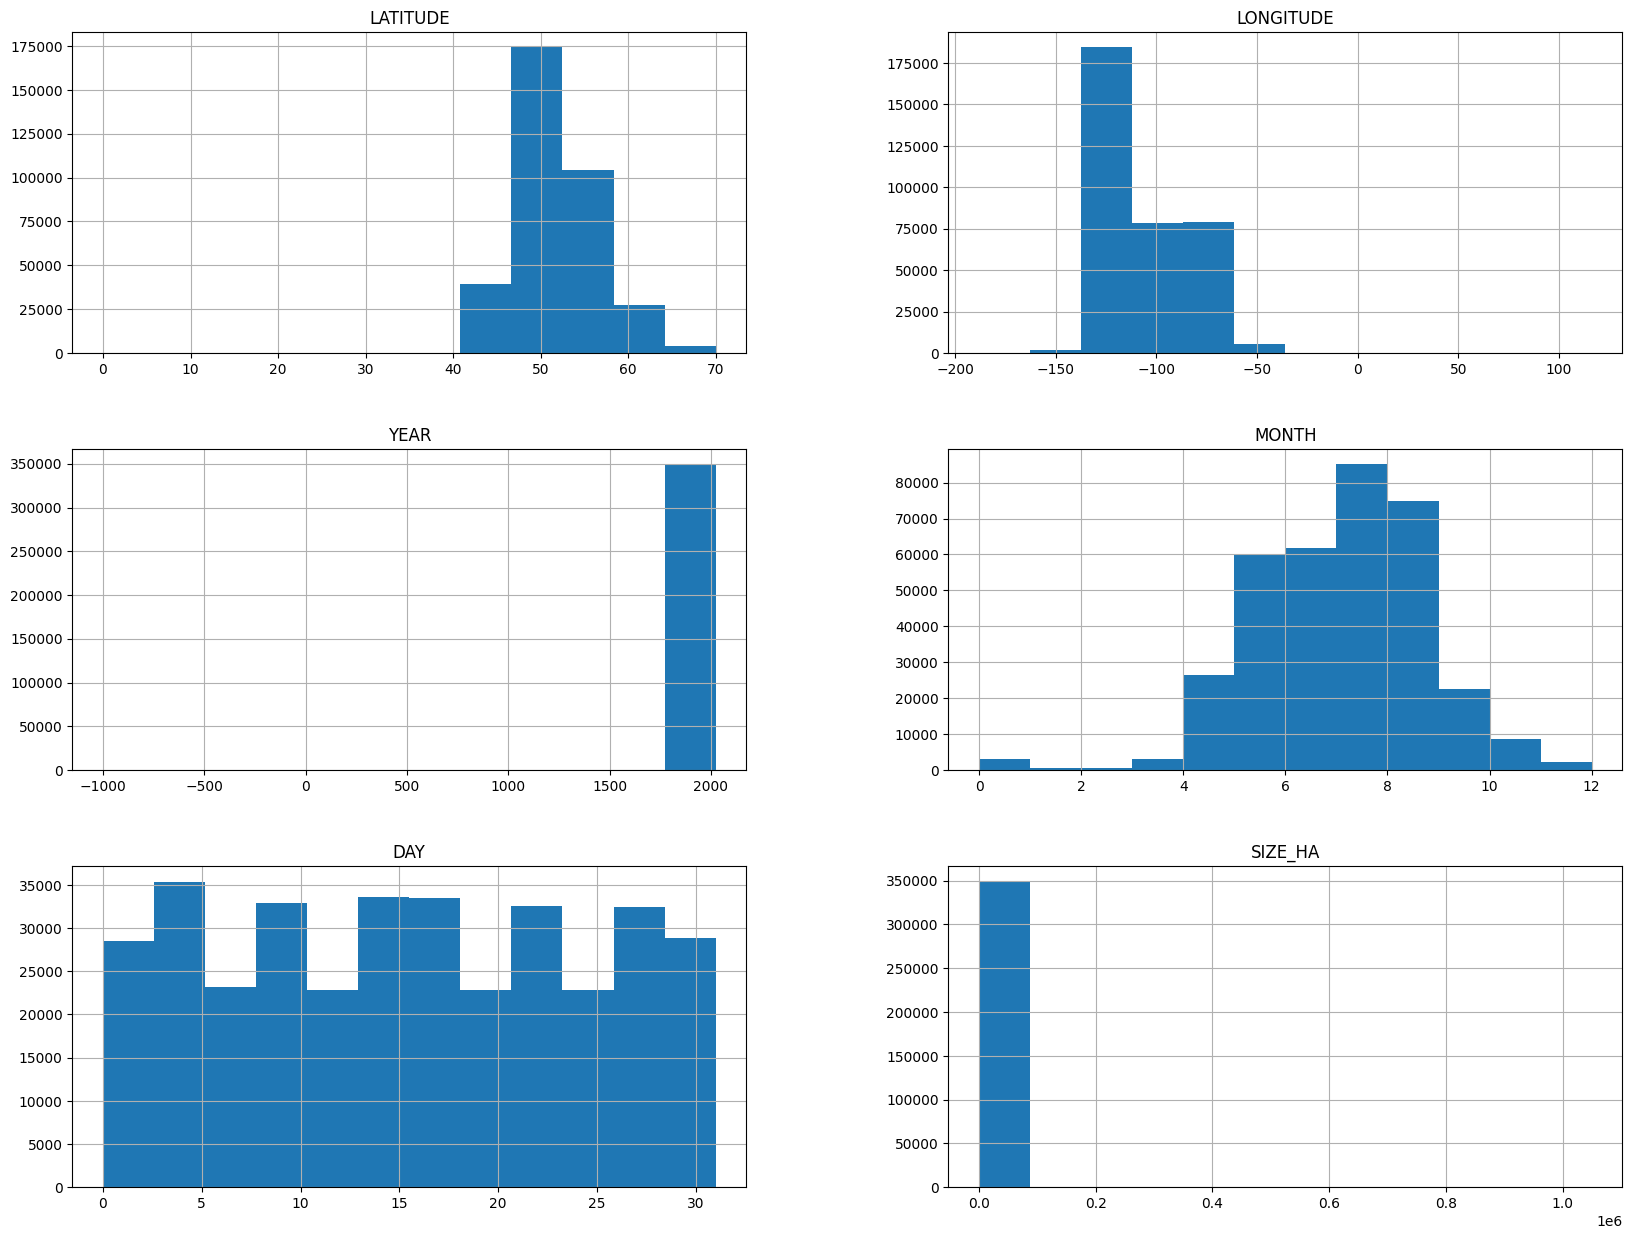

In [21]:
train_df.hist(bins=12, figsize=(20, 15));

We see a rise in frequency of fires in the summer months. However, there does not seem to be a specific day within months that leads to significantly more fires. We can also infer that a specific region of Canada is more at risk for fires, because there is a higher frequency of fires in a subset of longitude values and a subset of latitude values. To understand fires by geographical regions further, it makes sense to create a scatter plot of the LONGITUDE and LATITUDE features.

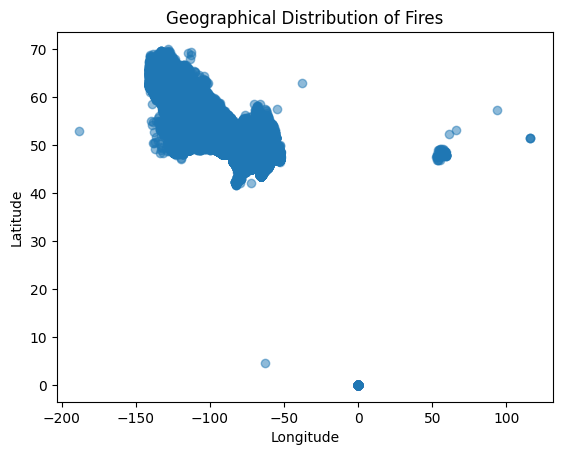

In [22]:
plt.scatter(train_df['LONGITUDE'], train_df['LATITUDE'], alpha=0.5)
plt.title('Geographical Distribution of Fires')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

It appears there are some outliers that make this plot harder to read. For now, we can focus on how many outliers we really have by calculating Z-scores. We will consider points with a Z-score above 3 or below -3 as outliers.

In [23]:
z_long = stats.zscore(train_df["LONGITUDE"])
z_lat = stats.zscore(train_df["LATITUDE"])
train_df["z_long"] = z_long
train_df["z_lat"] = z_lat
outliers = train_df[(train_df['z_long'].abs() > 3) | (train_df['z_lat'].abs() > 3)]
num_outliers = (outliers.shape[0])/(train_df.shape[0])
num_outliers * 100

0.7390100529418671

Less than 1% of our data points are outliers, so we can safely disregard them in our scatter plot and "zoom in" to the higher frequency region.

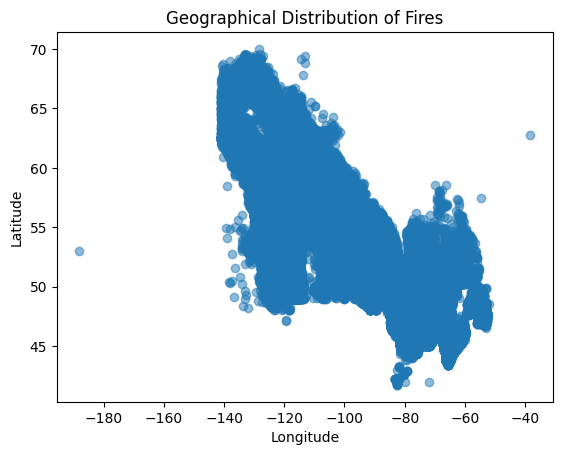

In [24]:
filtered = train_df[(train_df['LONGITUDE'] <= 0) & (train_df['LATITUDE'] >= 40)]
plt.scatter(filtered['LONGITUDE'], filtered['LATITUDE'], alpha=0.5)
plt.title('Geographical Distribution of Fires')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Feature Engineering
Now that we have a better understanding of the dataset, we can introduce our Fire Risk target. We can discretize relevant numerical features to make this new feature.

In [32]:
train_df_copy = train_df.copy()
# region_freq = train_df_copy.groupby(["LONGITUDE", "LATITUDE"]).size().reset_index(name="region_freq")

# train_df_copy = pd.merge(train_df_copy, region_freq, on=["LONGITUDE", "LATITUDE"], suffixes=("", "_region_freq"))
risk_score = train_df_copy.groupby(["LONGITUDE", "LATITUDE"]).size().reset_index(name="risk_score")

train_df_copy = pd.merge(train_df_copy, risk_score, on=["LONGITUDE", "LATITUDE"])

# train_df_copy["risk_score"] = train_df_copy["region_freq"] 

# risk mapped ordinally so 0:low, 1:medium, 2:high
discretizer = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform")
train_df_copy["fire_risk"] = discretizer.fit_transform(train_df_copy[["risk_score"]])

In [38]:
risk_score_0_df = train_df_copy[train_df_copy["fire_risk"] == 0.0]
risk_score_0_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348227 entries, 0 to 349250
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   NFDBFIREID  348227 non-null  object  
 1   SRC_AGENCY  348227 non-null  object  
 2   NAT_PARK    3299 non-null    object  
 3   FIRE_ID     348227 non-null  object  
 4   FIRENAME    51728 non-null   object  
 5   LATITUDE    348227 non-null  float64 
 6   LONGITUDE   348227 non-null  float64 
 7   YEAR        348227 non-null  int64   
 8   MONTH       348227 non-null  int64   
 9   DAY         348227 non-null  int64   
 10  REP_DATE    348227 non-null  object  
 11  ATTK_DATE   348227 non-null  object  
 12  OUT_DATE    348227 non-null  object  
 13  SIZE_HA     348227 non-null  float64 
 14  CAUSE       348227 non-null  object  
 15  CAUSE2      348227 non-null  object  
 16  FIRE_TYPE   234484 non-null  object  
 17  RESPONSE    45295 non-null   object  
 18  PROTZONE    69899 non-null   

In [39]:
risk_score_1_df = train_df_copy[train_df_copy["fire_risk"] == 1.0]
risk_score_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 170 to 26066
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NFDBFIREID  805 non-null    object  
 1   SRC_AGENCY  805 non-null    object  
 2   NAT_PARK    0 non-null      object  
 3   FIRE_ID     805 non-null    object  
 4   FIRENAME    98 non-null     object  
 5   LATITUDE    805 non-null    float64 
 6   LONGITUDE   805 non-null    float64 
 7   YEAR        805 non-null    int64   
 8   MONTH       805 non-null    int64   
 9   DAY         805 non-null    int64   
 10  REP_DATE    805 non-null    object  
 11  ATTK_DATE   805 non-null    object  
 12  OUT_DATE    805 non-null    object  
 13  SIZE_HA     805 non-null    float64 
 14  CAUSE       805 non-null    object  
 15  CAUSE2      805 non-null    object  
 16  FIRE_TYPE   702 non-null    object  
 17  RESPONSE    0 non-null      object  
 18  PROTZONE    0 non-null      object  
 19  PRESCRIBE

In [40]:
risk_score_2_df = train_df_copy[train_df_copy["fire_risk"] == 2.0]
risk_score_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 1619 to 8142
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NFDBFIREID  219 non-null    object  
 1   SRC_AGENCY  219 non-null    object  
 2   NAT_PARK    122 non-null    object  
 3   FIRE_ID     219 non-null    object  
 4   FIRENAME    94 non-null     object  
 5   LATITUDE    219 non-null    float64 
 6   LONGITUDE   219 non-null    float64 
 7   YEAR        219 non-null    int64   
 8   MONTH       219 non-null    int64   
 9   DAY         219 non-null    int64   
 10  REP_DATE    219 non-null    object  
 11  ATTK_DATE   219 non-null    object  
 12  OUT_DATE    219 non-null    object  
 13  SIZE_HA     219 non-null    float64 
 14  CAUSE       219 non-null    object  
 15  CAUSE2      219 non-null    object  
 16  FIRE_TYPE   98 non-null     object  
 17  RESPONSE    87 non-null     object  
 18  PROTZONE    101 non-null    object  
 19  PRESCRIBE

### Preprocessing, Pipelining and Feature Selection

At this point we have many different concerns to address before moving on to evaluating models. The first is that we have many features that do not relate to the target feature we are interested in analyzing. The second is that our numerical features have different scales so we should scale them before discretizing. The last is that any remaining categorical features need to be encoded.

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 349251 entries, 430011 to 249342
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   NFDBFIREID  349251 non-null  object  
 1   SRC_AGENCY  349251 non-null  object  
 2   NAT_PARK    3421 non-null    object  
 3   FIRE_ID     349251 non-null  object  
 4   FIRENAME    51920 non-null   object  
 5   LATITUDE    349251 non-null  float64 
 6   LONGITUDE   349251 non-null  float64 
 7   YEAR        349251 non-null  int64   
 8   MONTH       349251 non-null  int64   
 9   DAY         349251 non-null  int64   
 10  REP_DATE    349251 non-null  object  
 11  ATTK_DATE   349251 non-null  object  
 12  OUT_DATE    349251 non-null  object  
 13  SIZE_HA     349251 non-null  float64 
 14  CAUSE       349251 non-null  object  
 15  CAUSE2      349251 non-null  object  
 16  FIRE_TYPE   235284 non-null  object  
 17  RESPONSE    45382 non-null   object  
 18  PROTZONE    70000 non-nu

Referring to the data source, NFDBFIREID, FIRE_ID, FIRENAME, SRC_AGENCY and ACQ_DATE are related to how the fires are identified and reported. NAT_PARK and geometry are redundant since we already have location coordinates. REP_DATE is also redundant as we already have day/month/year attributes (which will be easier to work with anyway and require less preprocessing than REP_DATE). The data source also specifies some features that do not have a national standard. Therefore, these are not helpful to predict fire risk at a national level so we should drop them as well. These features are PROTZONE and FIRE_TYPE. We will also drop features that include additional information provided by either the agency or CFS as these have many null values and are too specific to be general to the entire dataset. In particular, we will drop CFS_NOTE1, CFS_NOTE2 and MORE_INFO. We can rid of the z-scores added earlier. ATTK_DATE has only been recorded for fires in 2023, so it will not be helpful as the majority of fires have no associated value. RESPONSE and PRESCRIBED have null values for more than half of the dataset, so we will also drop these. 

In [63]:
drop_features = ["NFDBFIREID", "FIRE_ID", "FIRENAME", "SRC_AGENCY", "ACQ_DATE", "NAT_PARK", "REP_DATE", "PROTZONE", "FIRETYPE",
            "CFS_NOTE1", "CFS_NOTE2", "MORE_INFO", "z_lat", "z_long", "RESPONSE", "PRESCRIBED", "geometry"]
numerical_features = ["LONGITUDE", "LATITUDE", "MONTH", "YEAR", "DAY", "SIZE_HA"]
categorical_features = []